In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GPS    = np.genfromtxt('rates.csv', delimiter=',', names=True, case_sensitive=True) 
faults = np.genfromtxt('faults.csv', delimiter=',', names=True, case_sensitive=True) 
coasts = np.genfromtxt('coasts.csv', delimiter=',', names=True, case_sensitive=True)


the original "map" locations have values like 4e6 meters - this just makes
the plots a little cleaner.  Doesn't affect any of the math at all.

In [3]:
faults['x']=faults['x']-GPS['x'].mean()
faults['y']=faults['y']-GPS['y'].mean()
GPS['x']=GPS['x']-GPS['x'].mean()
GPS['y']=GPS['y']-GPS['y'].mean()

GPS['UE']=GPS['UE']/1000 #%convert to meters/yr, since our units of distance are in meters
GPS['UN']=GPS['UN']/1000


Now we are going to make a grid of points, going from a range of x and y values that contains most of the region.  You will change the grid spacing and smoothing!

In [65]:
dx = 30e3 #grid spacing in meters
gridx = np.arange(GPS['x'].min(),GPS['x'].max(),dx) #this makes a vector of x values, spaced by dx
gridy = np.arange(GPS['y'].min(),GPS['y'].max(),dx) #this makes a vector of y values, spaced by dx

#how many x and y points do we have?  We use that later.
nx=np.size(gridx); 
ny=np.size(gridy);

#This makes a grid of x and y values from our two vectors
[x,y]=np.meshgrid(gridx,gridy)

#smoothing distance - this allows us to use points that are not just within
#our single grid box, while still making the ones in the box more
#"important".  Change this up!
alpha = 10e3; #in meters


In [66]:
m     = np.zeros([6,ny,nx]); #initialize an empty model vector 
count = x*0;                 #keep a vector of how many points we end up using for each box


In [67]:
for i in np.arange(0,ny): #loop over all ny rows
    for j in np.arange(0,nx): #loop over all nx columns
        #Calculate the distance from ALL GPS points to your grid box center.
        dists=np.sqrt(np.square(GPS['x']-x[i,j])+np.square(GPS['y']-y[i,j]))

        #this is the equation for a Gaussian curve, with width alpha
        weights = np.exp(-(np.square(dists))/(2*np.square(alpha)))       
        
        #only use points that are within 2*alpha from the center of our box, or the box size itself
        ind     = np.where((dists < 2*alpha) | (dists < dx/2))
        nd      = np.size(ind);   # number of "good" points
        
        sig      =  np.diag(np.hstack((weights[ind],weights[ind])))

        #data vector of just the points we are using
        d        = np.hstack((GPS['UE'][ind],GPS['UN'][ind]))
        z        = np.zeros(nd)
        o        = np.ones(nd)

        #%build G matrix
        G1    = np.column_stack((o,z,GPS['x'][ind],GPS['y'][ind],z,z))  #first set, UE 
        G2    = np.column_stack((z,o,z,z,GPS['x'][ind],GPS['y'][ind])) #2nd set, UN
        G     = np.concatenate((G1,G2),axis=0)
    
        Gt   = np.transpose(G)
        G3   = (Gt.dot(sig)).dot(G);
        
        # If the next value is very big or infinite, 
        #this means the matrix is not invertible, 
        #probably because you have < 6 points or 
        #points that are very close together
 
        rcond = np.linalg.cond(G3) 
    
        if np.isinf(rcond) or rcond >1e16:
            m[:,i,j]=np.nan
           
        else:
            Gg       = (np.linalg.inv(G3).dot(Gt)).dot(sig)
            m[:,i,j] = Gg.dot(d)
            count[i,j]=nd


Now we want to pull out the extension and shear components

In [68]:
dilatation = x*np.nan
shear      = x*np.nan

for i in np.arange(0,ny): #loop over all ny rows
    for j in np.arange(0,nx): #loop over all nx columns
        L  = [[m[2,i,j],m[3,i,j]],[m[4,i,j],m[5,i,j]]]
        W = (L-np.transpose(L))/2
        E = (L+np.transpose(L))/2
          
        dilatation[i,j] = np.trace(E)
        shear[i,j]      = E[0,0]-E[1,1]


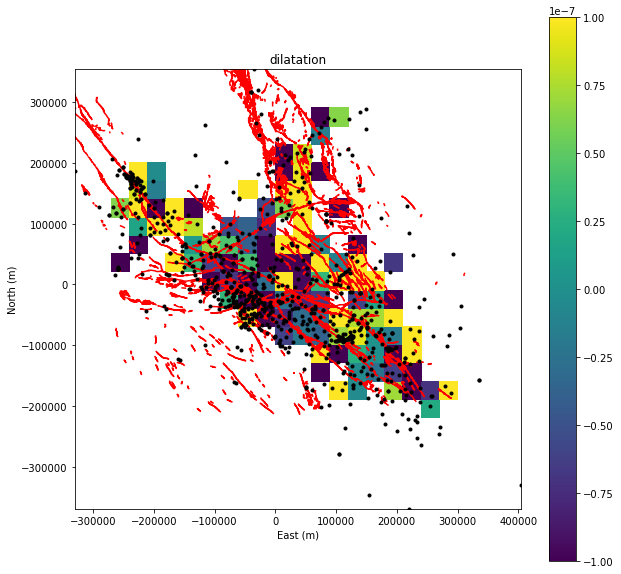

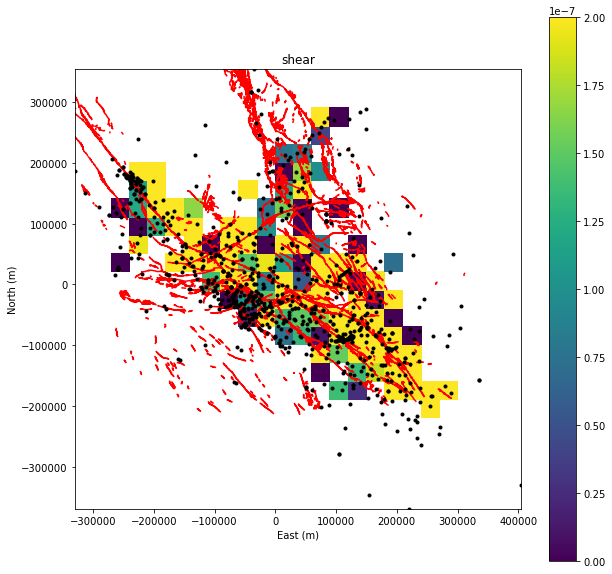

In [69]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)    
im=ax.pcolor(x,y,dilatation,vmin=-1e-7,vmax=1e-7)
ax.plot(faults['x'],faults['y'],'r')
ax.plot(GPS['x'],GPS['y'],'k.')
plt.axis('image')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.xlim(GPS['x'].min(), GPS['x'].max())
plt.ylim(GPS['y'].min(), GPS['y'].max())
plt.title('dilatation')
fig.colorbar(im,ax=ax)
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)     
im=ax.pcolor(x,y,shear,vmin=0,vmax=2e-7)
ax.plot(faults['x'],faults['y'],'r')
ax.plot(GPS['x'],GPS['y'],'k.')
plt.axis('image')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.xlim(GPS['x'].min(), GPS['x'].max())
plt.ylim(GPS['y'].min(), GPS['y'].max())
plt.title('shear');
fig.colorbar(im,ax=ax)
plt.show()
